### **Import Libraries**

We start by importing the libraries:

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import sklearn.metrics as metrics
from edge2vec3 import *
from transition3 import *
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import copy
import networkx as nx
import matplotlib.pyplot as plt
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report
import pickle

### **Load Data**

Decide which graph should be loaded. v1 corresponds to the small graph and v2 to the large graph.

In [8]:
rel1 = pd.read_csv('graph_edges_v2022-01-11.csv', header=0) #Monarch edges v1
rel2 = pd.read_csv('drug_target_edges.csv', header=0) # TTD edges v1
rel3 = pd.read_csv('drug_disease_edges.csv', header=0) # DrugCentral Edges v1

# rel1 = pd.read_csv('Graph3/monarch_edges_v2022-05-19.csv', header=0) #Monarch edges v2
# rel2 = pd.read_csv('Graph3/drug.target.final_v2.csv', header=0) # TTD edges v2
# rel3 = pd.read_csv('Graph3/drug_to_disease_final_v2.csv', header=0) # DrugCentral Edges v2

Put information from each data source in a single Dataframe.

In [9]:
rel1 = rel1[['subject_id', 'property_label', 'object_id']]
rel1.rename(columns = {'subject_id':'head', 'property_label':'relationship',
                              'object_id':'tail'}, inplace = True)

rel2 = rel2[['STRUCT_ID', 'NEW_ID']]
rel2['relationship'] = 'targets'
rel2.rename(columns = {'STRUCT_ID':'head', 
                              'NEW_ID':'tail'}, inplace = True)

rel3 = rel3[['DRUG_ID', 'ID']]
rel3['relationship'] = 'is substance that treats'
rel3.rename(columns = {'DRUG_ID':'head', 
                              'ID':'tail'}, inplace = True)



In [10]:
result = pd.concat([rel1, rel2, rel3])

Once again, select which graph (nodes) should be loaded. V1 corresponds to the small graph and V2 corresponds to the large graph.

In [12]:
nod1 = pd.read_csv('graph_nodes_v2022-01-11.csv', header=0) #Monarch nodes v1
nod2 = pd.read_csv('drug_nodes.csv', header=0) #DrugCentral Nodes v1

# nod1 = pd.read_csv('Graph3/monarch_nodes_v2022-05-19.csv', header=0) #Monarch nodes v2
# nod2 = pd.read_csv('Graph3/drug_nodes_v2.csv', header=0) #DrugCentral Nodes v2

In the next cells, information is preprocessed and put together. 

In [13]:
nod1 = nod1[['id', 'semantic_groups', 'preflabel']]
nod2['semantic_groups'] = 'DRUG'
nod2 = nod2[['STRUCT_ID','semantic_groups', 'DRUG_NAME']]
nod2.rename(columns = {'STRUCT_ID':'id', 'DRUG_NAME': 'preflabel'}, inplace = True)

In [14]:
nodes = pd.concat([nod1, nod2], ignore_index=True)

In [15]:
nodes['semantic_id'] = nodes.semantic_groups.astype('category').cat.codes

In [16]:
df = pd.merge(result, 
                  nodes,
                  left_on='head',
                  right_on='id',
                  how='left')

In [17]:
df = df.drop('id', axis = 1)
df.rename(columns = {'semantic_groups':'class_head'}, inplace = True)

In [18]:
df = pd.merge(df, 
                  nodes,
                  left_on='tail',
                  right_on='id',
                  how='left')

In [19]:
df = df.drop('id', axis = 1)
df.rename(columns = {'semantic_groups':'class_tail'}, inplace = True)

Now a unique index is given to every node. This might take a couple of minutes in the case of the small graph and a couple of hours in the case of the large graph. We recommend saving the resulted dataframe once it is finished.

In [20]:
index_head = []
index_tail = []
for ind, row in df.iterrows(): 
  if ind%50000 == 0: 
    print('{} iteration completed'.format(ind))
    
  ind_head = nodes[nodes['id'] == row['head']].index #change nodes to new_nodes for individual class index
  ind_tail = nodes[nodes['id'] == row['tail']].index #change nodes to new_nodes for individual class index
  index_head.append(int(ind_head[0]))
  index_tail.append(int(ind_tail[0]))
df['index_head'] = index_head
df['index_tail'] = index_tail

0 iteration completed
50000 iteration completed


Run the next frame to save the progress.

In [21]:
#df = pd.read_csv('edges.csv', header=0, index_col = 0)

### **Prepare E2V data**

Data will now be prepared to perform the Edge2Vec algorithm.

In [22]:
df['type'] = pd.factorize(df['relationship'], na_sentinel= len(set(pd.factorize( df['relationship'] )[0]))-1)[0]

In [23]:
edge2vec_df = df.drop(['head',	'relationship',	'tail',	'class_head',	'class_tail'], axis = 1)

In [24]:
edge2vec_df['index_head'] = edge2vec_df['index_head'].apply(str)
edge2vec_df['index_tail'] = edge2vec_df['index_tail'].apply(str)

In [25]:
G = nx.from_pandas_edgelist(edge2vec_df, 'index_head', 'index_tail', 'type', create_using= nx.DiGraph(), edge_key = (('type',int),('id',int)))
G = G.to_undirected()
for edge in G.edges():
  G[edge[0]][edge[1]]['weight'] = 1.0

In [26]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

('0', {})
('0', '1', {'type': 0, 'weight': 1.0})
Number of edges is 58435
Number of nodes is 10786


In [27]:
edge2vec_df

,preflabel_x,semantic_id_x,preflabel_y,semantic_id_y,index_head,index_tail,type
0,act-2,5,mitochondria alignment variant,1,0,1,0
1,VCL,3,SRC,3,2,3,1
2,SPTB,3,Congenital hemolytic anemia,1,4,5,0
3,mlc-4,5,Mlc2,5,6,7,2
4,MYBPC1,3,MYL4,3,8,9,1
...,...,...,...,...,...,...,...
93900,diphenidol,2,Nausea,1,10485,3166,18
93901,felodipine,2,Hypertension,1,10566,5024,18
93902,thiethylperazine,2,Nausea,1,10684,3166,18
93903,benzbromarone,2,Gout,1,10486,5835,18


### **DeepSnap**

Functions that will create our model are loaded:

In [28]:
class LinkPredModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, out_size, num_layers, aggr, dropout):
        super(LinkPredModel, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.convs.append(SAGEConv(input_size, hidden_size, normalize=True, aggr=aggr))
        self.bns.append(nn.BatchNorm1d(hidden_size))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_size, hidden_size, normalize=True, aggr=aggr))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.convs.append(SAGEConv(hidden_size, out_size, normalize=True, aggr=aggr))
        self.bns.append(nn.BatchNorm1d(out_size))

        self.dropout = dropout
        self.loss_fn = torch.nn.BCEWithLogitsLoss()


    def forward(self, x, edge_index, edge_label_index, training = True):

        for i in range(len(self.convs) - 1):
          x = self.convs[i](x, edge_index)
          x = self.bns[i](x)
          x = F.leaky_relu(x)
          x = F.dropout(x, p=self.dropout, training=training)
        
        x = self.convs[-1](x, edge_index)  
        x = self.bns[-1](x)

        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())
        pred = torch.sum(nodes_first * nodes_second, dim=-1)
        return pred, x
    
    def loss(self, pred, label):
        return self.loss_fn(pred, label)

In [29]:
def train(model, dataloaders, optimizer, args, ho = False, monitorate = False):
    val_max = 0
    best_model = model
    best_x = None
    train_per = []
    val_per = []
    test_per = []
    loss_per = []
    
    print('Start Train Function')
    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
            #print('Starting Loop')
            batch.to(args["device"])
            #print('Model Train')
            model.train()
            #print('Optimizing')
            optimizer.zero_grad()
            #print('Predicting')
            #print(batch)
            pred, x = model(feat, edge_index, edge_label_index)
            #print('Loss')
            loss = model.loss(pred, batch.edge_label.type(pred.dtype))

            loss.backward()
            optimizer.step()

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)
            
            

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
                best_x = x
            if ho: 
                tune.report(val_auc=score_val, train_auc = score_train, test_auc = score_test )
            
            loss_per.append(loss.detach().numpy())
            train_per.append(score_train)
            val_per.append(score_val)
            test_per.append(score_test)
            
            
    return best_model, best_x, [loss_per, train_per, val_per, test_per]

def test(model, dataloader, args):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred)
        score += roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return score

### **Train Single Model**

In the following section a single model will be trained. If you would like to perform a hyperparameter optimization, please go to the Hyperparameter Optimization section. If you would like to use an already trained model, please go to section Prediction.

#### **E2V**

In this first part the Edge2Vec Algorithm will be run to obtain node features

In [30]:
type_size = len(set(df['relationship']))
epoch = 10 #number of epochs
num_walks = 2 #number of walks
walk_length = 7 #length of the walks
directed = True
p = 0.7 #p parameter: probability of returning to the previous node
q = 1 #q parameter: parameter that switches between depth first search and breadth first search
e_step = 3

print("begin to initialize transition matrix")
trans_matrix = initialize_edge_type_matrix(type_size)
#print(trans_matrix)
print("------begin to simulate walk---------")
for i in range(epoch):
    walks = simulate_walks_1(G,num_walks, walk_length,trans_matrix,directed,p,q)#M step
    #print(len(walks))
    print(str(i), "th iteration for Upating transition matrix!")
    trans_matrix = update_trans_matrix(walks,type_size,e_step)#E step
    #print("trans_matrix: ",trans_matrix)
# print walks 
print("------finish!---------")

begin to initialize transition matrix
------begin to simulate walk---------
Walk iteration:
1 / 2
2 / 2
0 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
1 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
2 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
3 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
4 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
5 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
6 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
7 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
8 th iteration for Upating transition matrix!
Walk iteration:
1 / 2
2 / 2
9 th iteration for Upating transition matrix!
------finish!---------


In [31]:
dimensions = 64 #Dimension of the output/node embedding
window_size = walk_length - 1
workers = 8
epochs = 10 #Number of Epochs
print("------begin to simulate walk---------")
walks = simulate_walks_2(G,num_walks, walk_length,trans_matrix,directed,p,q) 
#print(len(walks))
w2v_model = Word2Vec(walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, epochs=epochs)

------begin to simulate walk---------
Walk iteration:
1 / 2
2 / 2


Run the following cell to save the node embeddings:

In [ ]:
# word_vectors = w2v_model.wv
# word_vectors.save("./models/w2v_small_undirected.dvectors")

Node Embeddings are saved in a dataframe that will be later used to complete the graph

In [33]:
e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(w2v_model.wv.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(w2v_model.wv[key])})

In [34]:
e2v_embedding = e2v_embedding.sort_values('Node')

In [35]:
e2v_embedding

,Node,Embedding
0,0,"[0.8515103, 0.17504132, 0.34829515, -0.1785091..."
1,1,"[0.34295264, -0.14321333, 0.39002275, 0.018474..."
2,2,"[0.5356681, -0.11159097, 0.46081716, 0.8273119..."
3,3,"[0.68724906, -0.82964116, 0.16809992, 1.233597..."
4,4,"[0.37636793, -0.27946845, 0.4493493, 0.6272564..."
...,...,...
10781,10781,"[0.21990496, -0.14938083, 0.13318075, 0.087620..."
10782,10782,"[0.15110298, -0.037945595, 0.22745086, 0.37257..."
10783,10783,"[0.37962982, -0.45042858, -0.02412971, 0.51094..."
10784,10784,"[0.17040692, -0.050629023, 0.34905368, 0.52511..."


#### **Model**

In this section the GNN model will be trained. We start by creating a graph and adding our newly obtained node features.

In [36]:
G = nx.Graph()
for ind, node in e2v_embedding.iterrows(): 
  G.add_node(node['Node'], node_feature=torch.Tensor(node['Embedding']))
for ind, edge in df.iterrows(): 
  G.add_edge(edge['index_head'], edge['index_tail'])

In [37]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.8515,  0.1750,  0.3483, -0.1785,  0.9668, -1.0942,  0.0912, -0.1687,
         0.0569, -0.0123,  0.0880, -0.5833,  0.4899, -0.5513,  0.4869,  0.1419,
        -0.8501,  0.1869,  0.4067,  0.9043,  0.7174,  0.7558,  0.4939, -1.0376,
        -0.1034, -0.3981, -0.3708,  0.5258,  0.2590,  0.1137,  0.1024,  0.0635,
         0.0331, -0.3423,  0.0467, -0.4646, -0.3632, -0.0276, -0.0550,  0.2338,
         0.3678,  0.6524,  0.0026, -0.2118,  1.0470, -0.2462,  0.1976, -0.2408,
         0.1629, -0.2033,  0.0790, -0.4554, -0.6968,  0.3385,  0.5090, -0.0663,
         0.0732, -0.3231, -0.2327,  0.5250,  0.3144,  0.1166,  0.7174, -0.4868])})
(0, 1, {})
Number of edges is 58435
Number of nodes is 10786


We now create the dataloaders that will be used to train, validate and test our model. Here the data will be splitted and the negative edge sampling will be performed. 

In [38]:
dataset = GraphDataset(
        G,
        task='link_pred',
        edge_train_mode="all"
    )

datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In [39]:
dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}

Finally, our model is trained. Args dictionary contains the hyperparameters that can be changed to modify our model.  

In [40]:
args = {
    "device" : 'cpu', 
    "hidden_dim" : 264,
    'output_dim':64,
    "epochs" : 150, 
    'lr': 0.07, 
    'aggr': 'mean', 
    'layers': 2, 
    'dropout': 0.2
}


model = LinkPredModel(input_dim, args["hidden_dim"], args['output_dim'], args['layers'], args['aggr'],args['dropout'] ).to(args["device"])

optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model, best_x, performance = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

Start Train Function
Epoch: 001, Train: 0.9486, Val: 0.9311, Test: 0.9354, Loss: 2.31647


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 002, Train: 0.9476, Val: 0.9326, Test: 0.9363, Loss: 2.12151


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 003, Train: 0.9451, Val: 0.9349, Test: 0.9379, Loss: 1.93632


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 004, Train: 0.9549, Val: 0.9443, Test: 0.9478, Loss: 1.83008


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 005, Train: 0.9564, Val: 0.9461, Test: 0.9502, Loss: 1.73544


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 006, Train: 0.9597, Val: 0.9484, Test: 0.9538, Loss: 1.65593


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 007, Train: 0.9625, Val: 0.9495, Test: 0.9557, Loss: 1.54085


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 008, Train: 0.9639, Val: 0.9504, Test: 0.9564, Loss: 1.45223


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 009, Train: 0.9652, Val: 0.9511, Test: 0.9567, Loss: 1.36976


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 010, Train: 0.9667, Val: 0.9520, Test: 0.9570, Loss: 1.27539


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 011, Train: 0.9674, Val: 0.9530, Test: 0.9575, Loss: 1.21737


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 012, Train: 0.9676, Val: 0.9535, Test: 0.9578, Loss: 1.12774


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 013, Train: 0.9680, Val: 0.9538, Test: 0.9580, Loss: 1.06978


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 014, Train: 0.9680, Val: 0.9540, Test: 0.9585, Loss: 0.99149


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 015, Train: 0.9683, Val: 0.9538, Test: 0.9588, Loss: 0.94199


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 016, Train: 0.9678, Val: 0.9536, Test: 0.9590, Loss: 0.86772


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 017, Train: 0.9672, Val: 0.9530, Test: 0.9590, Loss: 0.81033


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 018, Train: 0.9674, Val: 0.9526, Test: 0.9590, Loss: 0.76116


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 019, Train: 0.9668, Val: 0.9520, Test: 0.9588, Loss: 0.70884


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 020, Train: 0.9654, Val: 0.9518, Test: 0.9587, Loss: 0.67429


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 021, Train: 0.9654, Val: 0.9525, Test: 0.9592, Loss: 0.64284


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 022, Train: 0.9663, Val: 0.9542, Test: 0.9605, Loss: 0.61911


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 023, Train: 0.9656, Val: 0.9559, Test: 0.9619, Loss: 0.59583


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 024, Train: 0.9665, Val: 0.9574, Test: 0.9634, Loss: 0.55674


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 025, Train: 0.9686, Val: 0.9590, Test: 0.9650, Loss: 0.54823


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 026, Train: 0.9698, Val: 0.9607, Test: 0.9667, Loss: 0.53227


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 027, Train: 0.9721, Val: 0.9624, Test: 0.9684, Loss: 0.51944


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 028, Train: 0.9732, Val: 0.9642, Test: 0.9702, Loss: 0.51246


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 029, Train: 0.9748, Val: 0.9659, Test: 0.9718, Loss: 0.49399


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 030, Train: 0.9770, Val: 0.9675, Test: 0.9734, Loss: 0.48572


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 031, Train: 0.9780, Val: 0.9689, Test: 0.9748, Loss: 0.48019


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.9792, Val: 0.9703, Test: 0.9762, Loss: 0.47128


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 033, Train: 0.9805, Val: 0.9716, Test: 0.9773, Loss: 0.46590


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 034, Train: 0.9810, Val: 0.9727, Test: 0.9783, Loss: 0.46231


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.9817, Val: 0.9736, Test: 0.9792, Loss: 0.45440


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.9831, Val: 0.9743, Test: 0.9798, Loss: 0.44943


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 037, Train: 0.9831, Val: 0.9749, Test: 0.9804, Loss: 0.44289


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 038, Train: 0.9842, Val: 0.9754, Test: 0.9808, Loss: 0.44307


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 039, Train: 0.9847, Val: 0.9759, Test: 0.9811, Loss: 0.43855


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 040, Train: 0.9850, Val: 0.9763, Test: 0.9814, Loss: 0.43626


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 041, Train: 0.9856, Val: 0.9767, Test: 0.9817, Loss: 0.43473


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 042, Train: 0.9860, Val: 0.9771, Test: 0.9818, Loss: 0.43092


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 043, Train: 0.9857, Val: 0.9775, Test: 0.9820, Loss: 0.42776


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 044, Train: 0.9858, Val: 0.9777, Test: 0.9821, Loss: 0.42803


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 045, Train: 0.9866, Val: 0.9780, Test: 0.9822, Loss: 0.42486


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 046, Train: 0.9869, Val: 0.9783, Test: 0.9822, Loss: 0.42601


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 047, Train: 0.9871, Val: 0.9785, Test: 0.9823, Loss: 0.42319


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 048, Train: 0.9868, Val: 0.9786, Test: 0.9822, Loss: 0.42248


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 049, Train: 0.9874, Val: 0.9787, Test: 0.9822, Loss: 0.42116


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 050, Train: 0.9879, Val: 0.9787, Test: 0.9822, Loss: 0.41990


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 051, Train: 0.9875, Val: 0.9788, Test: 0.9822, Loss: 0.41956


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 052, Train: 0.9877, Val: 0.9789, Test: 0.9822, Loss: 0.41784


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 053, Train: 0.9876, Val: 0.9789, Test: 0.9822, Loss: 0.41625


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 054, Train: 0.9883, Val: 0.9790, Test: 0.9822, Loss: 0.41440


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 055, Train: 0.9882, Val: 0.9790, Test: 0.9822, Loss: 0.41469


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 056, Train: 0.9886, Val: 0.9792, Test: 0.9823, Loss: 0.41440


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 057, Train: 0.9884, Val: 0.9793, Test: 0.9824, Loss: 0.41163


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 058, Train: 0.9891, Val: 0.9794, Test: 0.9825, Loss: 0.41316


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 059, Train: 0.9891, Val: 0.9796, Test: 0.9825, Loss: 0.41001


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 060, Train: 0.9892, Val: 0.9797, Test: 0.9827, Loss: 0.41194


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 061, Train: 0.9897, Val: 0.9799, Test: 0.9828, Loss: 0.41210


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 062, Train: 0.9894, Val: 0.9800, Test: 0.9829, Loss: 0.40879


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 063, Train: 0.9896, Val: 0.9801, Test: 0.9830, Loss: 0.41047


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 064, Train: 0.9903, Val: 0.9803, Test: 0.9831, Loss: 0.40971


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 065, Train: 0.9902, Val: 0.9804, Test: 0.9833, Loss: 0.40710


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 066, Train: 0.9904, Val: 0.9806, Test: 0.9834, Loss: 0.40753


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 067, Train: 0.9906, Val: 0.9807, Test: 0.9835, Loss: 0.40666


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.9908, Val: 0.9809, Test: 0.9836, Loss: 0.40635


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 069, Train: 0.9911, Val: 0.9810, Test: 0.9837, Loss: 0.40644


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.9912, Val: 0.9811, Test: 0.9838, Loss: 0.40518


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 071, Train: 0.9910, Val: 0.9812, Test: 0.9839, Loss: 0.40601


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.9910, Val: 0.9813, Test: 0.9840, Loss: 0.40500


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 073, Train: 0.9913, Val: 0.9814, Test: 0.9840, Loss: 0.40395


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.9915, Val: 0.9814, Test: 0.9841, Loss: 0.40545


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 075, Train: 0.9915, Val: 0.9815, Test: 0.9841, Loss: 0.40432


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.9917, Val: 0.9816, Test: 0.9842, Loss: 0.40389


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 077, Train: 0.9918, Val: 0.9817, Test: 0.9843, Loss: 0.40326


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.9917, Val: 0.9818, Test: 0.9843, Loss: 0.40281


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 079, Train: 0.9919, Val: 0.9818, Test: 0.9844, Loss: 0.40323


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 080, Train: 0.9920, Val: 0.9819, Test: 0.9845, Loss: 0.40274


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 081, Train: 0.9920, Val: 0.9820, Test: 0.9845, Loss: 0.40192


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 082, Train: 0.9922, Val: 0.9820, Test: 0.9846, Loss: 0.40154


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 083, Train: 0.9927, Val: 0.9821, Test: 0.9846, Loss: 0.40253


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 084, Train: 0.9923, Val: 0.9821, Test: 0.9847, Loss: 0.40056


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 085, Train: 0.9925, Val: 0.9821, Test: 0.9847, Loss: 0.40166


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 086, Train: 0.9926, Val: 0.9821, Test: 0.9847, Loss: 0.39933


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 087, Train: 0.9924, Val: 0.9821, Test: 0.9847, Loss: 0.40128


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 088, Train: 0.9927, Val: 0.9821, Test: 0.9847, Loss: 0.39877


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.9928, Val: 0.9821, Test: 0.9848, Loss: 0.40038


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 090, Train: 0.9929, Val: 0.9821, Test: 0.9848, Loss: 0.40015


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 091, Train: 0.9929, Val: 0.9822, Test: 0.9849, Loss: 0.40065


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 092, Train: 0.9930, Val: 0.9822, Test: 0.9849, Loss: 0.40005


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 093, Train: 0.9931, Val: 0.9822, Test: 0.9849, Loss: 0.39832


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 094, Train: 0.9933, Val: 0.9823, Test: 0.9850, Loss: 0.39971


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 095, Train: 0.9930, Val: 0.9823, Test: 0.9850, Loss: 0.40038


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 096, Train: 0.9934, Val: 0.9823, Test: 0.9850, Loss: 0.39857


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 097, Train: 0.9934, Val: 0.9824, Test: 0.9851, Loss: 0.39871


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 098, Train: 0.9933, Val: 0.9824, Test: 0.9851, Loss: 0.39918


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 099, Train: 0.9932, Val: 0.9825, Test: 0.9852, Loss: 0.39811


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 100, Train: 0.9934, Val: 0.9825, Test: 0.9852, Loss: 0.39850


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 101, Train: 0.9937, Val: 0.9826, Test: 0.9853, Loss: 0.39707


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 102, Train: 0.9937, Val: 0.9826, Test: 0.9853, Loss: 0.39833


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 103, Train: 0.9938, Val: 0.9826, Test: 0.9854, Loss: 0.39815


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 104, Train: 0.9938, Val: 0.9827, Test: 0.9854, Loss: 0.39778


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 105, Train: 0.9935, Val: 0.9827, Test: 0.9854, Loss: 0.39793


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 106, Train: 0.9940, Val: 0.9827, Test: 0.9855, Loss: 0.39708


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 107, Train: 0.9938, Val: 0.9828, Test: 0.9855, Loss: 0.39875


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 108, Train: 0.9940, Val: 0.9828, Test: 0.9855, Loss: 0.39726


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 109, Train: 0.9940, Val: 0.9828, Test: 0.9856, Loss: 0.39832


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 110, Train: 0.9939, Val: 0.9828, Test: 0.9856, Loss: 0.39745


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 111, Train: 0.9941, Val: 0.9828, Test: 0.9856, Loss: 0.39748


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 112, Train: 0.9941, Val: 0.9828, Test: 0.9856, Loss: 0.39660


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 113, Train: 0.9942, Val: 0.9828, Test: 0.9857, Loss: 0.39624


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 114, Train: 0.9941, Val: 0.9828, Test: 0.9857, Loss: 0.39505


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 115, Train: 0.9941, Val: 0.9829, Test: 0.9857, Loss: 0.39642


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 116, Train: 0.9943, Val: 0.9829, Test: 0.9857, Loss: 0.39520


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 117, Train: 0.9940, Val: 0.9829, Test: 0.9857, Loss: 0.39568


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 118, Train: 0.9943, Val: 0.9829, Test: 0.9858, Loss: 0.39616


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 119, Train: 0.9944, Val: 0.9829, Test: 0.9858, Loss: 0.39525


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 120, Train: 0.9943, Val: 0.9829, Test: 0.9858, Loss: 0.39512


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 121, Train: 0.9945, Val: 0.9829, Test: 0.9858, Loss: 0.39549


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 122, Train: 0.9945, Val: 0.9830, Test: 0.9858, Loss: 0.39450


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 123, Train: 0.9945, Val: 0.9830, Test: 0.9859, Loss: 0.39558


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 124, Train: 0.9945, Val: 0.9830, Test: 0.9859, Loss: 0.39467


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 125, Train: 0.9945, Val: 0.9830, Test: 0.9859, Loss: 0.39531


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 126, Train: 0.9944, Val: 0.9830, Test: 0.9859, Loss: 0.39518


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 127, Train: 0.9949, Val: 0.9830, Test: 0.9859, Loss: 0.39378


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 128, Train: 0.9945, Val: 0.9830, Test: 0.9859, Loss: 0.39447


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 129, Train: 0.9946, Val: 0.9831, Test: 0.9860, Loss: 0.39384


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 130, Train: 0.9948, Val: 0.9831, Test: 0.9860, Loss: 0.39480


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 131, Train: 0.9948, Val: 0.9831, Test: 0.9860, Loss: 0.39403


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 132, Train: 0.9947, Val: 0.9831, Test: 0.9861, Loss: 0.39377


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 133, Train: 0.9949, Val: 0.9831, Test: 0.9861, Loss: 0.39334


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 134, Train: 0.9946, Val: 0.9831, Test: 0.9861, Loss: 0.39469


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 135, Train: 0.9950, Val: 0.9832, Test: 0.9862, Loss: 0.39283


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 136, Train: 0.9949, Val: 0.9832, Test: 0.9862, Loss: 0.39366


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 137, Train: 0.9949, Val: 0.9832, Test: 0.9862, Loss: 0.39352


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 138, Train: 0.9950, Val: 0.9832, Test: 0.9862, Loss: 0.39386


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 139, Train: 0.9949, Val: 0.9833, Test: 0.9863, Loss: 0.39318


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 140, Train: 0.9951, Val: 0.9833, Test: 0.9863, Loss: 0.39263


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 141, Train: 0.9950, Val: 0.9834, Test: 0.9863, Loss: 0.39206


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 142, Train: 0.9952, Val: 0.9835, Test: 0.9864, Loss: 0.39281


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 143, Train: 0.9951, Val: 0.9835, Test: 0.9865, Loss: 0.39143


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 144, Train: 0.9952, Val: 0.9836, Test: 0.9865, Loss: 0.39148


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 145, Train: 0.9952, Val: 0.9836, Test: 0.9865, Loss: 0.39218


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 146, Train: 0.9950, Val: 0.9836, Test: 0.9866, Loss: 0.39187


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 147, Train: 0.9950, Val: 0.9836, Test: 0.9866, Loss: 0.39260


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 148, Train: 0.9951, Val: 0.9837, Test: 0.9866, Loss: 0.39149


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 149, Train: 0.9952, Val: 0.9837, Test: 0.9866, Loss: 0.39151
Train: 0.9951, Val: 0.9837, Test: 0.9866


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Run this cell to save the model: 

In [ ]:
#torch.save(best_model.state_dict(), './models/model_big_final.pth')

Run this cell to save the parameters of the model: 

In [ ]:
# import pickle
# with open('./models/args_final.pkl', 'wb') as f:
#     pickle.dump(args, f)

The following cell will show the learning curve of the model. It will show the AUC-ROC score of every dataset (train, validation, test) as well as the loss in every epoch. 

Text(0.5, 0, 'Epochs')

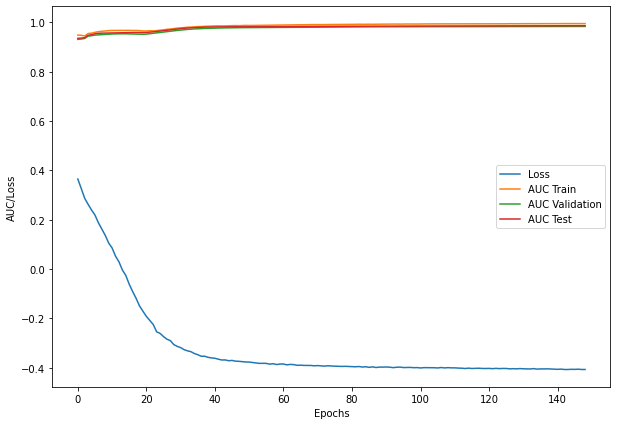

In [43]:
plt.figure(figsize= (10,7))
plt.plot(np.log10(performance[0]), label = 'Loss')
plt.plot(performance[1], label = 'AUC Train')
plt.plot(performance[2], label = 'AUC Validation')
plt.plot(performance[3], label = 'AUC Test')
plt.legend()
plt.ylabel('AUC/Loss')
plt.xlabel('Epochs')

To obtain the ROC curve of the test set, run the next two cells: 

In [44]:
for batch in dataloaders['test']:
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    batch.to(args["device"])
    pred, x = best_model(feat, edge_index, edge_label_index, training = False)
    pred = torch.sigmoid(pred)
    score = roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    print(score)

0.9866034566420289


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


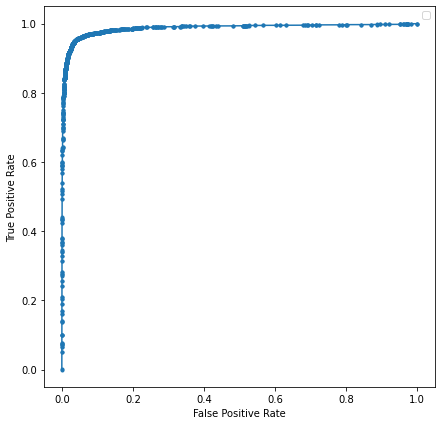

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
# plot the roc curve for the model
plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

To obtain the F1-Score in the test set, run the following cells: 

In [46]:
from sklearn.metrics import f1_score
def test_f1(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += f1_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy(), score

In [47]:
true_label, pred_label, best_test_f1 = test_f1(best_model, dataloaders['test'], args, 0.75)
print('F1-Score in the test set:', best_test_f1)

F1-Score in the test set: 0.9561773568661214


To obtain the classification report run the following cell:

In [48]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     11688
           1       0.96      0.95      0.96     11688

    accuracy                           0.96     23376
   macro avg       0.96      0.96      0.96     23376
weighted avg       0.96      0.96      0.96     23376



To obtain the confusion matrix run the following cells: 

In [49]:
from sklearn.metrics import confusion_matrix
def test_cm(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += confusion_matrix(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    return score

In [50]:
table = test_cm(best_model, dataloaders['train'], args, 0.8)
print(table)

[[91128  2368]
 [ 2200 91296]]


c:\Users\pablo\anaconda3\envs\master\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


### Hyperparameter Optimization

Run this section only if you are interested in performing the hyperparamter optimization. If you have already trained your model you can skip to the next section

In [51]:
def optim(args): 

  trans_matrix = initialize_edge_type_matrix(args['type_size'])
  for i in range(args['epoch_e2v']):
    walks = simulate_walks_1(args['G'], args['num_walks'], args['walk_length'], trans_matrix, True , args['p'], args['q'])#M step
    #print('Len Walks:', len(walks))
    #print(str(i), "th iteration for Upating transition matrix!")
    trans_matrix = update_trans_matrix(walks,args['type_size'],3)#E step
    #print("trans_matrix: ",trans_matrix)
  walks = simulate_walks_2(args['G'],args['num_walks'], args['walk_length'],trans_matrix,True,args['p'],args['q'])
  w2v_model = Word2Vec(walks, vector_size=args['dimensions_e2v'], window=args['walk_length']-1, min_count=0, sg=1, workers=8, epochs=args['epoch_e2v'])
  #print('Edge2Vec Ended!')
  e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
  #print('Vocab:', len(w2v_model.wv.index_to_key))
  for idx, key in enumerate(w2v_model.wv.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(w2v_model.wv[key])})
  e2v_embedding = e2v_embedding.sort_values('Node')
  #print('Len E2V:', len(e2v_embedding))
  G2 = nx.Graph()
  for ind, node in e2v_embedding.iterrows(): 
    G2.add_node(node['Node'], node_feature=torch.Tensor(node['Embedding']))
  for ind, edge in args['df'].iterrows(): 
    G2.add_edge(edge['index_head'], edge['index_tail'])
#   print('Graph Builded')
#   print("Number of edges is {}".format(G2.number_of_edges()))
#   print("Number of nodes is {}".format(G2.number_of_nodes()))

  dataset = GraphDataset(
        G2,
        task='link_pred',
        edge_train_mode="all"
    )
  #print('Loading Datasets')
  datasets = {}
  datasets['train'], datasets['val'], datasets['test']= dataset.split(
              transductive=True, split_ratio=[0.8, 0.1, 0.1])
  #print('Train Nodes:', datasets['train'].num_nodes)
  input_dim = datasets['train'].num_node_features
  #print('Train Features:', input_dim)

  #print('Loading Model')
  model = LinkPredModel(input_dim, args["hidden_dim"], args['output_dim'], args['layers'], args['aggr'], args['dropout']).to('cpu')
  #print('Loading Optimizer')
  optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)
  #print('Loading dataloaders')
  dataloaders = {split: DataLoader(
              ds, collate_fn=Batch.collate([]),
              batch_size=1, shuffle=(split=='train'))
              for split, ds in datasets.items()}
  # print(dataloaders['train'])
  # for i, batch in enumerate(dataloaders['train']): 
  #   print('Batch:', batch)
  # print('Starting Training')
  best_model, best_x = train(model, dataloaders, optimizer, args, ho = False)
  log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
  best_train_roc = test(best_model, dataloaders['train'], args)
  best_val_roc = test(best_model, dataloaders['val'], args)
  best_test_roc = test(best_model, dataloaders['test'], args)
  print('AUC:', best_test_roc)
  print(log.format(best_train_roc, best_val_roc, best_test_roc))
  #torch.save(best_model.state_dict(), './models/model' + str(best_val_roc) + '.pth')
  tune.report(accuracy=best_val_roc)
  


Select the different parameters that you would like to test in the search and run the cell:

In [ ]:
args = {
    'G': G,
    'device': 'cpu', 
    "hidden_dim" : tune.choice([64, 128, 256]),
    'output_dim': tune.choice([64, 128, 256]),
    "epochs" : tune.choice([100, 150, 200]),
    'type_size' : len(set(df['relationship'])),
    'epoch_e2v' : tune.choice([5, 10]),
    'num_walks' : tune.choice([2, 4, 6]),
    'walk_length' : tune.choice([3, 5, 7]),
    'p' : tune.choice([0.5, 0.75, 1]),
    'q' : tune.choice([0.5, 0.75, 1]),
    'dimensions_e2v' : tune.choice([32, 64, 128]),
    'df': df, 
    'lr': tune.loguniform(1e-4, 1e-1), 
    'aggr': tune.choice(['mean', 'sum']), 
    'dropout': tune.choice([0, 0.1, 0.2]), 
    'layers': tune.choice([2, 4, 6])
}

scheduler = ASHAScheduler(
        max_t=10,
        grace_period=1,
        reduction_factor=2)

result = tune.run(
        tune.with_parameters(optim),
        resources_per_trial={"gpu": 2}, #change this value according to the gpu units you would like to use
        config=args,
        metric="val_auc",
        mode="max",
        num_samples=30, #select the maximum number of models you would like to test
        scheduler=scheduler, 
        resume = False, 
        local_dir="./results"
    )

Print the best configuration:

In [ ]:
best_trial = result.get_best_trial("val_auc")

In [ ]:
print("Best trial config: {}".format(best_trial.config))

### **Predictions**

If you have already trained a model and you would like to load it, start by loading the saved arguments:

In [58]:
with open('./models/args_final.pkl', 'rb') as f:
    loaded_args = pickle.load(f)

Next, load the saved Edge2Vec embedding: 

In [62]:
from gensim.models import KeyedVectors
node_feat = KeyedVectors.load("./models/w2v_small_undirected.dvectors", mmap='r')

Create a pandas dataframe with the embeddings and create the graph. Take into account that you must have your edges loaded previously: 

In [63]:
e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})

In [64]:
e2v_embedding = e2v_embedding.sort_values('Node')

In [65]:
G = nx.Graph()
for ind, node in e2v_embedding.iterrows(): 
  G.add_node(node['Node'], node_feature=torch.Tensor(node['Embedding']))
for ind, edge in df.iterrows(): 
  G.add_edge(edge['index_head'], edge['index_tail'])

In [66]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.8515,  0.1750,  0.3483, -0.1785,  0.9668, -1.0942,  0.0912, -0.1687,
         0.0569, -0.0123,  0.0880, -0.5833,  0.4899, -0.5513,  0.4869,  0.1419,
        -0.8501,  0.1869,  0.4067,  0.9043,  0.7174,  0.7558,  0.4939, -1.0376,
        -0.1034, -0.3981, -0.3708,  0.5258,  0.2590,  0.1137,  0.1024,  0.0635,
         0.0331, -0.3423,  0.0467, -0.4646, -0.3632, -0.0276, -0.0550,  0.2338,
         0.3678,  0.6524,  0.0026, -0.2118,  1.0470, -0.2462,  0.1976, -0.2408,
         0.1629, -0.2033,  0.0790, -0.4554, -0.6968,  0.3385,  0.5090, -0.0663,
         0.0732, -0.3231, -0.2327,  0.5250,  0.3144,  0.1166,  0.7174, -0.4868])})
(0, 1, {})
Number of edges is 58435
Number of nodes is 10786


Load the GNN model:

In [67]:
best_model =  LinkPredModel(len(e2v_embedding['Embedding'][0]), loaded_args["hidden_dim"], loaded_args['output_dim'], loaded_args['layers'], loaded_args['aggr'],loaded_args['dropout'] ).to(loaded_args["device"])

In [69]:
best_model.load_state_dict(torch.load('./models/model_big_final.pth'))

<All keys matched successfully>

Define the score function: 

In [70]:
def score(x, id1, id2): 
  n1 = x[id1]
  n2 = x[id2]
  score = torch.Tensor([torch.sum(n1 * n2, dim=-1)])
  p = torch.sigmoid(score).cpu().detach().numpy()
  return p

Check the symptoms/phenotypes of the disease. If testing for Duchenne Muscular Dystrophy you can run the cell as it is; if you would like to test other disease, please change the ID in df['head'] == 'ID' to the targeted disease ID:

In [71]:
symptoms = df[(df['head'] == 'MONDO:0010679') & (df['relationship'] == 'has phenotype')]

In [72]:
name = []
for i in symptoms['tail']: 
    name.append(nodes[nodes['id'] == i]['preflabel'].item())
symptoms['preflabel'] = name

C:\Users\pablo\AppData\Local\Temp/ipykernel_5104/3685212348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms['preflabel'] = name


In [73]:
symptoms

,head,relationship,tail,class_head,preflabel_x,semantic_id_x,class_tail,preflabel_y,semantic_id_y,index_head,index_tail,type,preflabel
608,MONDO:0010679,has phenotype,HP:0001252,DISO,Duchenne muscular dystrophy,1,DISO,Hypotonia,1,323,1008,0,Hypotonia
3181,MONDO:0010679,has phenotype,HP:0001328,DISO,Duchenne muscular dystrophy,1,DISO,Specific learning disability,1,323,1898,0,Specific learning disability
8391,MONDO:0010679,has phenotype,HP:0011675,DISO,Duchenne muscular dystrophy,1,DISO,Arrhythmia,1,323,3456,0,Arrhythmia
15936,MONDO:0010679,has phenotype,HP:0001635,DISO,Duchenne muscular dystrophy,1,DISO,Congestive heart failure,1,323,1739,0,Congestive heart failure
19211,MONDO:0010679,has phenotype,HP:0001644,DISO,Duchenne muscular dystrophy,1,DISO,Dilated cardiomyopathy,1,323,1771,0,Dilated cardiomyopathy
20634,MONDO:0010679,has phenotype,HP:0008981,DISO,Duchenne muscular dystrophy,1,DISO,Calf muscle hypertrophy,1,323,2367,0,Calf muscle hypertrophy
30416,MONDO:0010679,has phenotype,HP:0001270,DISO,Duchenne muscular dystrophy,1,DISO,Motor delay,1,323,3122,0,Motor delay
30432,MONDO:0010679,has phenotype,HP:0003560,DISO,Duchenne muscular dystrophy,1,DISO,Muscular dystrophy,1,323,385,0,Muscular dystrophy
31176,MONDO:0010679,has phenotype,HP:0000750,DISO,Duchenne muscular dystrophy,1,DISO,Delayed speech and language development,1,323,3514,0,Delayed speech and language development
34153,MONDO:0010679,has phenotype,HP:0002791,DISO,Duchenne muscular dystrophy,1,DISO,Hypoventilation,1,323,4577,0,Hypoventilation


This function will return the score between a certain node (selected by its ID) and all the other nodes in the graph: 

In [74]:
def candidates(nodes, id, x): 
  ind = nodes[nodes['id'] == id].index.values.astype(int)[0]
  predictions = nodes
  scores = []
  for i in range(len(x)):  
    s = score(x, i, ind)
    scores.append(s)
  predictions['Score'] = scores
  return predictions

Obtain the embeddings using the loaded/trained model:

In [75]:
from deepsnap.graph import Graph
DeepG = Graph(G)

In [76]:
_, best_x = best_model(DeepG.node_feature, DeepG.edge_index, DeepG.edge_label_index, training = False)

List the candidates:

In [77]:
predictions = candidates(nodes, 'HP:0100543', best_x)
predictions[predictions['semantic_groups'] == 'DRUG'].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic_groups,preflabel,semantic_id,Score
10748,4483,DRUG,carfilzomib,2,[0.9287874]
10746,4359,DRUG,bosutinib,2,[0.9279146]
10561,1045,DRUG,erlotinib,2,[0.9254562]
10737,4187,DRUG,crizotinib,2,[0.9248997]
10492,391,DRUG,bortezomib,2,[0.92229176]
10516,681,DRUG,clioquinol,2,[0.8997521]
10719,3514,DRUG,quercetin,2,[0.8980857]
10771,5260,DRUG,acalabrutinib,2,[0.89490706]
10500,522,DRUG,carvedilol,2,[0.8927505]
10704,2835,DRUG,nicotinic acid,2,[0.8866504]


In [78]:
df[(df['head'] == 'HGNC:2928') & (df['relationship'] == 'has phenotype')]

,head,relationship,tail,class_head,preflabel_x,semantic_id_x,class_tail,preflabel_y,semantic_id_y,index_head,index_tail,type
121,HGNC:2928,has phenotype,HP:0003202,GENE,DMD,3,DISO,Skeletal muscle atrophy,1,67,227,0
847,HGNC:2928,has phenotype,HP:0012704,GENE,DMD,3,DISO,Widened subarachnoid space,1,67,1309,0
1195,HGNC:2928,has phenotype,HP:0000219,GENE,DMD,3,DISO,Thin upper lip vermilion,1,67,1690,0
2421,HGNC:2928,has phenotype,HP:0002465,GENE,DMD,3,DISO,Poor speech,1,67,2661,0
4447,HGNC:2928,has phenotype,HP:0003323,GENE,DMD,3,DISO,Progressive muscle weakness,1,67,3687,0
...,...,...,...,...,...,...,...,...,...,...,...,...
89460,HGNC:2928,has phenotype,HP:0000494,GENE,DMD,3,DISO,Downslanted palpebral fissures,1,67,1212,0
89794,HGNC:2928,has phenotype,HP:0002342,GENE,DMD,3,DISO,"Intellectual disability, moderate",1,67,5025,0
92155,HGNC:2928,has phenotype,HP:0001250,GENE,DMD,3,DISO,Seizure,1,67,1644,0
92335,HGNC:2928,has phenotype,HP:0002515,GENE,DMD,3,DISO,Waddling gait,1,67,4574,0


### **Plots**

In [79]:
from sklearn.preprocessing import StandardScaler
z = StandardScaler().fit_transform(best_x.detach().numpy())

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)
principalComponents = pca.fit_transform(z)
principalDf = pd.DataFrame(data = principalComponents[:, [0,1]]
             , columns = ['principal component 1', 'principal component 2'])

In [81]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(best_x.detach().numpy())

In [82]:
tsneDf = pd.DataFrame(data = X_tsne
             , columns = ['t-SNE 1', 't-SNE 2'])

In [431]:
finaltsne = pd.concat([tsneDf, nodes[['semantic_groups']].reset_index()], axis = 1)

In [432]:
finalDf = pd.concat([principalDf, nodes[['semantic_groups']].reset_index()], axis = 1)

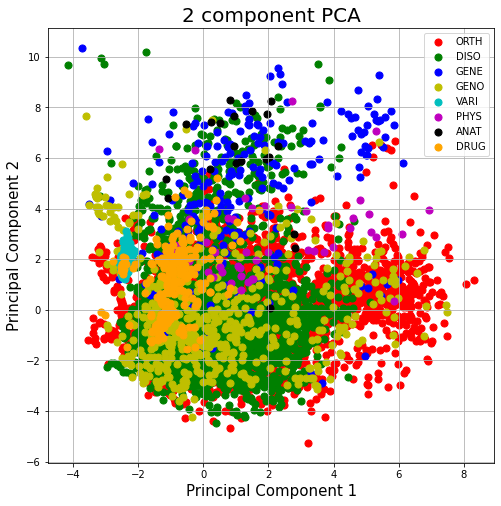

In [489]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets =list(pd.unique(nodes['semantic_groups']))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['semantic_groups'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

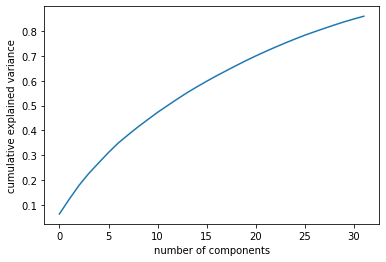

In [487]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [437]:
%matplotlib inline
plt.close('all')

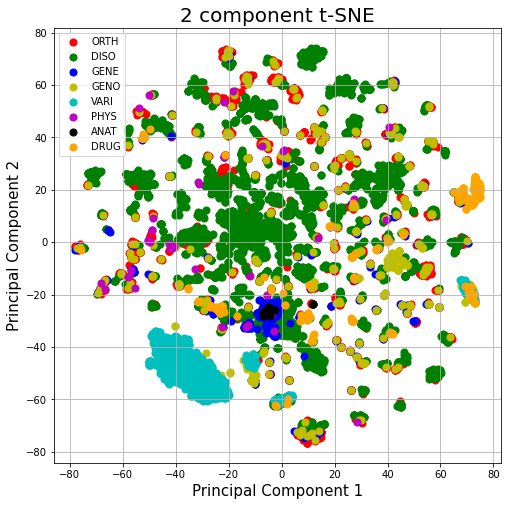

In [438]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets =list(pd.unique(nodes['semantic_groups']))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finaltsne['semantic_groups'] == target
    ax.scatter(finaltsne.loc[indicesToKeep, 't-SNE 1']
               , finaltsne.loc[indicesToKeep, 't-SNE 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### **GNNExplainner**

In this section explanations will be provided for a given prediction. We start by loading the functions that we will be using: 

In [94]:
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm

from torch_geometric.nn.models.explainer import (
    Explainer,
    clear_masks,
    set_masks,
)

EPS = 1e-15


class GNNExplainer(Explainer):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model
            returns the logarithm of probabilities), :obj:`"prob"` (the
            model returns probabilities), :obj:`"raw"` (the model returns raw
            scores) and :obj:`"regression"` (the model returns scalars).
            (default: :obj:`"log_prob"`)
        feat_mask_type (str, optional): Denotes the type of feature mask
            that will be learned. Valid inputs are :obj:`"feature"` (a single
            feature-level mask for all nodes), :obj:`"individual_feature"`
            (individual feature-level masks for each node), and :obj:`"scalar"`
            (scalar mask for each each node). (default: :obj:`"feature"`)
        allow_edge_mask (boolean, optional): If set to :obj:`False`, the edge
            mask will not be optimized. (default: :obj:`True`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
        **kwargs (optional): Additional hyper-parameters to override default
            settings in :attr:`~torch_geometric.nn.models.GNNExplainer.coeffs`.
    """

    coeffs = {
        'edge_size': 0.00005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 feat_mask_type: str = 'feature', allow_edge_mask: bool = True,
                 log: bool = True, **kwargs):
        super().__init__(model, lr, epochs, num_hops, return_type, log)
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']
        self.allow_edge_mask = allow_edge_mask
        self.feat_mask_type = feat_mask_type
        self.coeffs.update(kwargs)

    def _initialize_masks(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1

        if self.feat_mask_type == 'individual_feature':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        elif self.feat_mask_type == 'scalar':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        else:
            self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

    def _clear_masks(self):
        clear_masks(self.model)
        self.node_feat_masks = None
        self.edge_mask = None

    def _loss(self, log_logits, prediction, node_idx: Optional[int] = None):
        if self.return_type == 'regression':
            if node_idx is not None and node_idx >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, batch=batch,
                                                 **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)
        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            loss = self.get_loss(out, prediction, None)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid().squeeze()
        if self.allow_edge_mask:
            edge_mask = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.ones(edge_index.size(1))

        self._clear_masks()
        return node_feat_mask, edge_mask


    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.subgraph(node_idx, -x, edge_index, **kwargs)
        print('Edge Index 1:', edge_index)
        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)
        print('Prediction:', prediction)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        print('Edge Index 2:', edge_index)
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            print('X:', x)
            print('H:', h)
            print('Mask:', self.node_feat_mask.sigmoid())
            print('Edge Index 3:', edge_index)
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            print('Out:', out)
            print('Prediction:', prediction)
            loss = self.get_loss(out, prediction, mapping)
            print('Loss:', loss)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)
        print('Out:', out)
        print('Mapping:', mapping )
        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            print('Hard Edges:', hard_edge_mask)
            print('Len Hard Edges:', len(hard_edge_mask))
            print('Edges:', edge_mask)
            print('Len Edges:', len(edge_mask))      
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask


    def __repr__(self):
        return f'{self.__class__.__name__}()'
    
    def explain_link(self, node_idx1, node_indx2, x, edge_index, G,  **kwargs): 
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self._clear_masks()
        # for module in best_model.modules():  
        #   if isinstance(module, MessagePassing):
        #     #print(module._edge_mask)

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # dataset = GraphDataset(
        # G,
        # task='link_pred',
        # edge_train_mode="all")
        
        # dataloader = DataLoader(
        #     dataset, collate_fn=Batch.collate([]),
        #     batch_size=1, shuffle=False)
        
        # for i, batch in enumerate(dataloader):
        pred, emb = self.model(x, edge_index, edge_index)

        
        # print('Len Emb:', len(emb))
        # Only operate on a k-hop subgraph around `node_idx1`.

        node_indices = torch.tensor([node_idx1, node_idx2], dtype=torch.long)

        x1, edge_index1, mapping1, hard_edge_mask1, subset1, kwargs1 = \
            subgraph(node_indices, x, edge_index, flow='source_to_target', num_hops = self.num_hops, **kwargs)

        # print(edge_index1)

        # # Only operate on a k-hop subgraph around `node_idx2`.
        # x2, edge_index2, mapping2, hard_edge_mask2, subset2, kwargs2 = \
        #     self.subgraph(node_idx2, x, edge_index, **kwargs)

        #initial embedding
        node_embedding_1 = emb[node_idx1]
        node_embedding_2 = emb[node_idx2]

        # Get the initial prediction.       
        prediction = torch.Tensor([torch.sum(emb[node_idx1]* emb[node_idx2], dim=-1)]).requires_grad_()
        

        self._initialize_masks(x1, edge_index1)
        self.to(x1.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index1,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')
        
        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            criterion = torch.nn.MSELoss(reduction='sum')
            h = x1 
            # # print('X:', x1)
            # # print('H:', h)
            # # print('Mask:', self.node_feat_mask.sigmoid())
            # G1 = nx.Graph()
            # for ind, node in enumerate(h): 
            #   G1.add_node(ind, node_feature=node)
            # for i in range(edge_index1.size(1)): 
            #   G1.add_edge(edge_index1[0][i].item(), edge_index1[1][i].item())
            
            # # print("Number of edges is {}".format(G1.number_of_edges()))
            # # print("Number of nodes is {}".format(G1.number_of_nodes()))
            # dataset1 = GraphDataset(
            #   G1,
            #   task='link_pred',
            #   edge_train_mode="all")
            
            # dataloader1 = DataLoader(
            #     dataset1, collate_fn=Batch.collate([]),
            #     batch_size=1, shuffle=False)
        
            # for i, batch in enumerate(dataloader1):
            pred1, emb1 = self.model(h, edge_index1, edge_index1)
            
            # for module in self.model.modules():  
            #   if isinstance(module, MessagePassing):
            #     print(module._edge_mask)
              # module._loop_mask = loop_mask
              # module._apply_sigmoid = apply_sigmoid

            out = torch.tensor([torch.sum(emb1[mapping1[1]]* emb1[mapping1[0]], dim=-1)]).requires_grad_()
            # print('Out:', out)
            # print('Prediction:', prediction)
            loss = criterion(out, prediction)
            #loss = self.get_loss(out, prediction, mapping1)
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()
            # m = self.node_feat_mask.sigmoid()
            # node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
            # loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
            # ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            # loss = loss + self.coeffs['node_feat_ent'] * ent.mean()
            # print('Loss:', loss)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x1.new_zeros(num_nodes, x1.size(-1))
            new_mask[subset1] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x1.new_zeros(num_nodes, 1)
            new_mask[subset1] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()
        # print('Non Zero:', torch.count_nonzero(node_feat_mask))

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            # print('Hard Edges:', hard_edge_mask1)
            # print('Len Hard Edges:', len(hard_edge_mask1))
            # print('Non Zero:', torch.count_nonzero(hard_edge_mask1))
            # print('Edges:', edge_mask)
            # print('Len Edges:', len(edge_mask))            
            edge_mask[hard_edge_mask1] = self.edge_mask.detach().sigmoid()
            #print('Edge Mask:', self.edge_mask.detach().sigmoid())
            # print('Non Zero:', torch.count_nonzero(edge_mask))
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask1] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask


In [95]:
def maybe_num_nodes(index, num_nodes=None):
    return index.max().item() + 1 if num_nodes is None else num_nodes

In [96]:
def k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=False,
                   num_nodes=None, flow='source_to_target'):
    r"""Computes the :math:`k`-hop subgraph of :obj:`edge_index` around node
    :attr:`node_idx`.
    It returns (1) the nodes involved in the subgraph, (2) the filtered
    :obj:`edge_index` connectivity, (3) the mapping from node indices in
    :obj:`node_idx` to their new location, and (4) the edge mask indicating
    which edges were preserved.

    Args:
        node_idx (int, list, tuple or :obj:`torch.Tensor`): The central
            node(s).
        num_hops: (int): The number of hops :math:`k`.
        edge_index (LongTensor): The edge indices.
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        flow (string, optional): The flow direction of :math:`k`-hop
            aggregation (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)

    :rtype: (:class:`LongTensor`, :class:`LongTensor`, :class:`LongTensor`,
             :class:`BoolTensor`)
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    assert flow in ['source_to_target', 'target_to_source']
    if flow == 'target_to_source':
        row, col = edge_index
    else:
        col, row = edge_index

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    if isinstance(node_idx, (int, list, tuple)):
        node_idx = torch.tensor([node_idx], device=row.device).flatten()
    else:
        node_idx = node_idx.to(row.device)

    subsets = [node_idx]

    for _ in range(num_hops):
        node_mask.fill_(False)
        node_mask[subsets[-1]] = True
        torch.index_select(node_mask, 0, row, out=edge_mask)
        subsets.append(col[edge_mask])

    subset, inv = torch.cat(subsets).unique(return_inverse=True)
    inv = inv[:node_idx.numel()]

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    if relabel_nodes:
        node_idx = row.new_full((num_nodes, ), -1)
        node_idx[subset] = torch.arange(subset.size(0), device=row.device)
        edge_index = node_idx[edge_index]

    return subset, edge_index, inv, edge_mask

In [97]:
def subgraph(node_idx, x, edge_index, num_hops, **kwargs):
        r"""Returns the subgraph of the given node.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.
        :rtype: (Tensor, Tensor, LongTensor, LongTensor, LongTensor, dict)
        """
        num_nodes, num_edges = x.size(0), edge_index.size(0)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow = 'source_to_target')
        #print(subset)
        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new

In [98]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

In [123]:
from torch_geometric.data import Data
from torch_geometric.utils import get_num_hops, k_hop_subgraph, to_networkx
from inspect import signature

def visualize_subgraph(node_idx, edge_index_full,
                        edge_mask, nodes, y = None,
                        threshold = None,
                        edge_y = None,
                        node_alpha = None, seed= 10,
                       flow = 'source_to_target', 
                       num_hops = 1,node_label = 'preflabel',
                       edge_labels = None,
                       show_inactive = False,
                       remove_unconnected = False,
                       
                        **kwargs):
    r"""Visualizes the subgraph given an edge mask :attr:`edge_mask`.

    Args:
        node_idx (int): The node id to explain.
            Set to :obj:`None` to explain a graph.
        edge_index (LongTensor): The edge indices.
        edge_mask (Tensor): The edge mask.
        y (Tensor, optional): The ground-truth node-prediction labels used
            as node colorings. All nodes will have the same color
            if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
        threshold (float, optional): Sets a threshold for visualizing
            important edges. If set to :obj:`None`, will visualize all
            edges with transparancy indicating the importance of edges.
            (default: :obj:`None`)
        edge_y (Tensor, optional): The edge labels used as edge colorings.
        node_alpha (Tensor, optional): Tensor of floats (0 - 1) indicating
            transparency of each node.
        seed (int, optional): Random seed of the :obj:`networkx` node
            placement algorithm. (default: :obj:`10`)
        **kwargs (optional): Additional arguments passed to
            :func:`nx.draw`.

    :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    assert edge_mask.size(0) == edge_index_full.size(1)

    if node_idx is None or node_idx[0] < 0:
        hard_edge_mask = torch.BoolTensor([True] * edge_index_full.size(1),
                                          device=edge_mask.device)
        subset = torch.arange(edge_index_full.max().item() + 1,
                              device=edge_index_full.device)
        y = None

    else:
        
        # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, mapping_sub, hard_edge_mask = k_hop_subgraph(
            node_idx, num_hops, edge_index_full, relabel_nodes=True,
            num_nodes=None, flow=flow)
        

    edge_mask = edge_mask[hard_edge_mask]
    selected = (hard_edge_mask == True).nonzero(as_tuple=True)

    if threshold is not None:
        edge_mask = (edge_mask >= threshold).to(torch.float)

    if y is None:
        y = torch.zeros(edge_index.max().item() + 1,
                        device=edge_index.device)
    else:
        #print(y[subset])
        y = y[subset].to(torch.float) / y.max().item()
        

    if edge_y is None:
        edge_color = ['black'] * edge_index.size(1)
    else:
        colors = list(plt.rcParams['axes.prop_cycle'])
        edge_color = [
            colors[i % len(colors)]['color']
            for i in edge_y[hard_edge_mask]
        ]


    data = Data(edge_index=edge_index, att=edge_mask,
                edge_color=edge_color, y=y, num_nodes=y.size(0)).to('cpu')
    #print(data)
    G = to_networkx(data, node_attrs=['y'],
                    edge_attrs=['att', 'edge_color'])

    #print(G.number_of_nodes())
    #print(node_label)
    
    #print(mapping)

    #print(len(torch.stack((edge_index[0], edge_index[1])).unique()))
    #print(G.number_of_edges())
    G2 = copy.deepcopy(G)
    if num_hops >= 1 and not show_inactive: 
      for indx, edge in enumerate(G.edges): 
        if edge_mask[indx] <  limit:
          G2.remove_edge(edge[0], edge[1])
      removed_nodes = list(nx.isolates(G2))
      G2.remove_nodes_from(removed_nodes)

    
    if remove_unconnected:
        G2 = G2.to_undirected()
        for component in list(nx.connected_components(G2)):
            if mapping_sub[0].item() in component or mapping_sub[1].item() in component:
                continue
            else:
                for node in component:
                    G2.remove_node(node)
                    

    active = torch.tensor(list(G2.nodes()))

    mapping = {k: str(nodes.iloc[i][node_label]) + ' ' + str(i) for k, i in enumerate(subset.tolist())}
    mapping2 = {str(nodes.iloc[i][node_label]) + ' ' + str(i): i for k, i in enumerate(subset.tolist())}
    G2 = nx.relabel_nodes(G2, mapping)

    node_args = set(signature(nx.draw_networkx_nodes).parameters.keys())
    node_kwargs = {k: v for k, v in kwargs.items() if k in node_args}
    node_kwargs['node_size'] = kwargs.get('node_size') or 800
    node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

    label_args = set(signature(nx.draw_networkx_labels).parameters.keys())
    label_kwargs = {k: v for k, v in kwargs.items() if k in label_args}
    label_kwargs['font_size'] = kwargs.get('font_size') or 10

    pos = nx.spring_layout(G2, seed=seed)
    ax = plt.gca()
    for source, target, data in G2.edges(data=True):
        ax.annotate(
            '', xy=pos[target], xycoords='data', xytext=pos[source],
            textcoords='data', arrowprops=dict(
                arrowstyle="->",
                alpha=max(data['att'], 0.1),
                color=data['edge_color'],
                shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                connectionstyle="arc3,rad=0.1",
            ))

    if node_alpha is None:
        #print(active)
        nx.draw_networkx_nodes(G2, pos, node_color=y[active].tolist(),
                                **node_kwargs)
    else:
        node_alpha_subset = node_alpha[subset]
        assert ((node_alpha_subset >= 0) & (node_alpha_subset <= 1)).all()
        nx.draw_networkx_nodes(G2, pos, alpha=node_alpha_subset.tolist(),
                                node_color=y.tolist(), **node_kwargs)

    nx.draw_networkx_labels(G2, pos, **label_kwargs)

    if edge_labels is not None: 

      edge_labels_sub = {}
      for (n1,n2) in G2.edges(): 
        #print(n1)
        edge_labels_sub[(n1, n2)] = edge_labels[(mapping2[n1], mapping2[n2])]
      
      nx.draw_networkx_edge_labels(
      G2, pos,
      edge_labels=edge_labels_sub,
      font_color='red', 
      font_size = 10
  )

    return ax, G2

Reload the graph, this time including edge labels that will make the explanations more understandable. 

In [118]:
G = nx.Graph()
for ind, node in e2v_embedding.iterrows(): 
  G.add_node(node['Node'], node_feature=torch.Tensor(node['Embedding']))
for ind, edge in df.iterrows(): 
  G.add_edge(edge['index_head'], edge['index_tail'], edge_label = edge['relationship'])

Obtain the predictions:

In [119]:
predictions = candidates(nodes, 'HP:0003560', best_x)
predictions[predictions['semantic_groups'] == 'DRUG'].sort_values(by = ['Score'], ascending = False).head(5)

,id,semantic_groups,preflabel,semantic_id,Score
10472,231,DRUG,aprindine,2,[0.9036193]
10500,522,DRUG,carvedilol,2,[0.7852785]
10611,1795,DRUG,mezlocillin,2,[0.7438367]
10548,926,DRUG,disopyramide,2,[0.73676234]
10649,2173,DRUG,pinacidil,2,[0.7109113]


The next cell is the one that obtains the explanations. You must introduce the node IDs of the nodes you are interested in. If the ID of the node is an integer (i.e. 1809) you must introduce it as an integer (no ''). On the other hand, if it's a string (i.e. 'HP:0001644' or 'MESH:D008775') you must introduce it as a string (use ''). If you want to modify the size of the explanations, modify the 'size' parameter. If you want to modify the number of iterations, modify the iterations parameter. 

In [120]:
node_idx = get_node_idx('HP:0003560', nodes)
node_idx2 = get_node_idx(231, nodes)
x= torch.Tensor(e2v_embedding['Embedding'])
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64)
explainer = GNNExplainer(best_model, epochs=700, num_hops = 1, lr = 0.01)
edge_list = []
trigger = False
early_stop = 0
size = 15 #change size of the explanation
iterations = 10 #number of times GNNExplainer will be executed
while not trigger: 
  node_feat_mask, edge_mask = explainer.explain_link(node_idx, node_idx2, x, edge_index, G)
  #edge_list.append(edge_mask)
  G2 = copy.deepcopy(G)
  if size is not None: 
    limit = edge_mask.sort(descending = True)[0][size]
  else: 
    limit = 0.5
  #print(limit)
  for indx, edge in enumerate(G.edges): 
    if edge_mask[indx] <  limit:
      G2.remove_edge(edge[0], edge[1])
  #print(len(G2.edges))
  trigger = nx.has_path(G2, node_idx,node_idx2)
  early_stop += 1
  if early_stop == iterations and not trigger:
    print('No good explanation found after {} iterations'.format(early_stop))
    trigger = True
  elif trigger: 
    print('Explanation found!')

Explain node 385: 100%|██████████| 700/700 [00:00<00:00, 859.58it/s]


Explanation found!


Obtain a dictionary with all the edge-label keys:

In [121]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label'])
                    for n1, n2 in G.edges])

Plot the explanation:

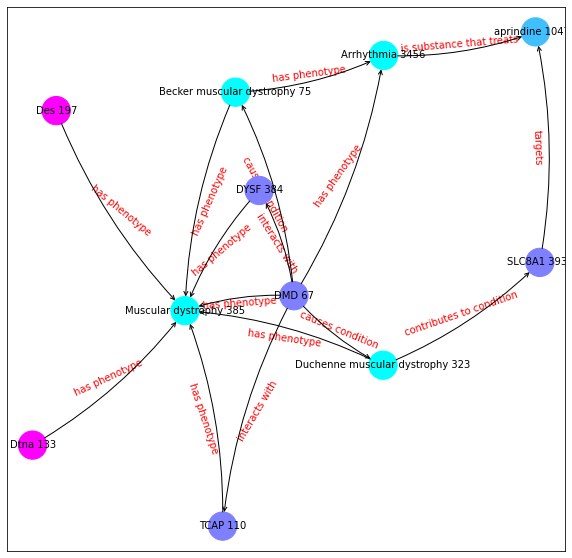

In [124]:
plt.figure(figsize=(10, 10))
ax, G_sub = visualize_subgraph(torch.tensor([node_idx, node_idx2], dtype=torch.long), edge_index, edge_mask, nodes = nodes, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = 1, threshold=limit, node_label = 'preflabel', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
plt.show()

### **Plots**

In this section several different plots are provided. Firstly, two dimensionality reduction techniques were applied, PCA and tSNE, to visualize the final embeddings: 

In [ ]:
from sklearn.preprocessing import StandardScaler
z = StandardScaler().fit_transform(best_x.detach().numpy())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)
principalComponents = pca.fit_transform(z)
principalDf = pd.DataFrame(data = principalComponents[:, [0,1]]
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(best_x.detach().numpy())

In [ ]:
tsneDf = pd.DataFrame(data = X_tsne
             , columns = ['t-SNE 1', 't-SNE 2'])

In [ ]:
finaltsne = pd.concat([tsneDf, nodes[['semantic_groups']].reset_index()], axis = 1)
finalDf = pd.concat([principalDf, nodes[['semantic_groups']].reset_index()], axis = 1)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets =list(pd.unique(nodes['semantic_groups']))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['semantic_groups'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
%matplotlib inline
plt.close('all')

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets =list(pd.unique(nodes['semantic_groups']))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finaltsne['semantic_groups'] == target
    ax.scatter(finaltsne.loc[indicesToKeep, 't-SNE 1']
               , finaltsne.loc[indicesToKeep, 't-SNE 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Next, we can plot the degree histogram: 

In [667]:
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

Text(0, 0.5, '(Log) Frequency')

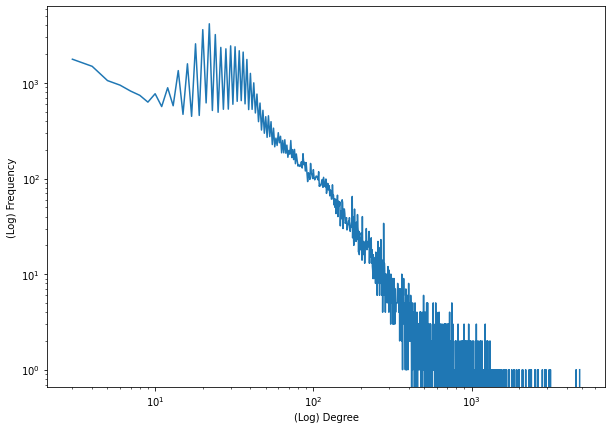

In [690]:
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(10, 7)) 
plt.loglog(degrees[3:], degree_freq[3:]) 
plt.xlabel('(Log) Degree')
plt.ylabel('(Log) Frequency')

Finally, we can visualize the metagraph: 

In [383]:
metagraph = df[['class_head', 'class_tail', 'relationship']]

In [384]:
metagraph = metagraph.drop_duplicates()

In [385]:
G_meta = nx.MultiGraph()
meta_dict = {}
for ind, edge in metagraph.iterrows(): 
  G_meta.add_edge(edge['class_head'], edge['class_tail'], edge_label = edge['relationship'])
  

In [386]:
d = {'ORTH': 0, 'DISO': 1, 'GENE': 2, 'GENO': 3, 'VARI': 4, 'ANAT': 5, 'DRUG':6 , 'PHYS': 7}
values = [d.get(node, 0.25) for node in G_meta.nodes()]

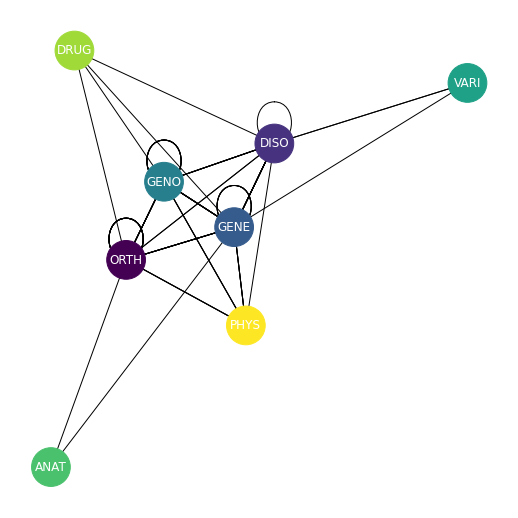

In [387]:
plt.figure(figsize = (7,7))
nx.draw(G_meta, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white', node_size = 1500)